In [1]:
%%capture
# If running on colab, it will crash the first time
# since install_colab.sh restarts this notebook
try:
    from icevision.all import *
except:
    !pip install -U torch-snippets typer imgaug
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

In [2]:
# Setup Data
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

# If running from colab
if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain
if not os.path.exists('open-images-bus-trucks/data'):
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz -O open-images-bus-trucks.tar.xz
    unzip_file('open-images-bus-trucks.tar.xz', './')
    P('open-images-bus-trucks').mv('data')
    makedir('open-images-bus-trucks')
    P('data').mv('open-images-bus-trucks/data')
    

/mnt/d04d289c-d0a7-4fd4-b883-ff227b3a8695/githubs/AutoTrain


In [3]:
!cat configs/object_detection.ini

[project]
owner: sizhky
name: open-images-bus-trucks
location: ${project.name}
model_directory: ${project.location}/models
type: object_detection
num_classes: 2
auto_train_lib: auto_train_${project.type}
classes: ["Bus", "Truck"]

[label_studio]
base_data_dir: /tmp/data/

[label_studio_ml]
app_name: ${project.name}/my_ml_model
script_path: ${project.auto_train_lib}/script.py

[online_training]
save_dir: ${project.model_directory}/model.pt

[architecture]
model_type: ultralytics.yolov5
backbone: small
pretrained: True
size: 384
[architecture.extra_args]
img_size: ${architecture.size}

[training]
dir: ${project.location}/data
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/annotations/mini_open_images_train_coco_format.json
train_ratio: 0.8

[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.data]
train_dir: ${training.dir}/train
validation_dir: ${training.dir}/validation

[training.scheme]
epochs: 25
lr: 1e-

In [4]:
os.environ['CONFIG'] = 'configs/object_detection.ini'
!python auto_train_object_detection/train.py train-model

INFO     - 15225 files found at open-images-bus-trucks/data/images | torch_snippets.paths:inner:24
15225 images found
WARNING  - This function will be deprecated, instantiate the concrete classes instead: `COCOBBoxParser`, `COCOMaskParser`, `COCOKeypointsParser` | icevision.parsers.coco_parser:coco:24
INFO     - 
CLASSES INFERRED FROM open-images-bus-trucks/data/annotations/mini_open_images_train_coco_format.json: <ClassMap: {'background': 0, 'Bus': 1, 'Truck': 2}> | auto_train_object_detection.model:<module>:17
100%|███████████████████████████████████████| 612/612 [00:00<00:00, 3369.14it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|████████████████████████████████████████| 82/82 [00:00<00:00, 21013.80it/s]
INFO     - Training from scratch! | __main__:train_model:32
INFO     - LR Plot is saved at open-images-bus-trucks/find_lr_plot.png | __main__:find_best_learning_rate:22
INFO     - Suggested LRs: 0.0009120108559727668 and 7.585775847473997e-07 | __main__

  0%|          | 0/2 [00:00<?, ?it/s]

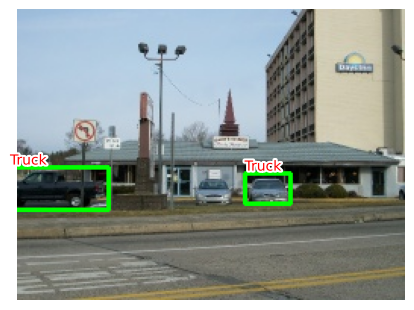

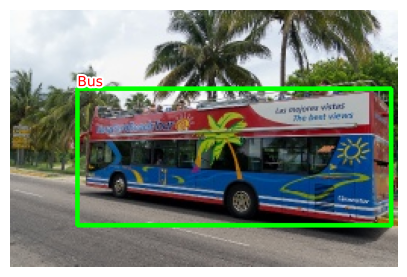

In [35]:
os.environ['CONFIG'] = 'configs/object_detection.ini'
from auto_train_object_detection.infer import predict_on_folder_of_images as infer
o = infer('open-images-bus-trucks/data/images/')

for fpath, pred in o:
    show(read(fpath, 1), bbs=pred.bbs, texts=pred.labels)